# Tabulation API Example: Adiabatic Flamelet Models

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Building adiabatic equilibrium, Burke-Schumann, and strained laminar flamelet (SLFM) models

In the introductory flamelet demonstration we used methods on the `Flamelet` class to compute steady and unsteady solutions to the flamelet equations. We used these solutions to build SLFM and FPV chemistry libraries. Here we use the following methods to directly build similar libraries without having to even make a `Flamelet` instance.

- adiabatic equilibrium: `build_adiabatic_eq_library`
- adiabatic Burke-Schumann: `build_adiabatic_bs_library`
- adiabatic SLFM: `build_adiabatic_slfm_library`

In [1]:
from spitfire import (ChemicalMechanismSpec, 
                      FlameletSpec, 
                      build_adiabatic_eq_library,
                      build_adiabatic_bs_library,
                      build_adiabatic_slfm_library)
import matplotlib.pyplot as plt
import numpy as np

mech = ChemicalMechanismSpec(cantera_input='heptane-liu-hewson-chen-pitsch-highT.yaml', group_name='gas')

pressure = 101325.

air = mech.stream(stp_air=True)
air.TP = 1200., pressure

fuel = mech.stream('TPY', (300., pressure, 'NXC7H16:1'))

flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='equilibrium',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=34)

With the flamelet specifications all set up, we next use the high-level tabulation methods to easily build some flamelet models.

First up are the unstrained models - equilibrium (infinitely fast chemistry) and Burke-Schumann (idealized single-step combustion).

In [2]:
l_eq = build_adiabatic_eq_library(flamelet_specs, verbose=False)
l_bs = build_adiabatic_bs_library(flamelet_specs, verbose=False)

Next up is the adiabatic strained laminar flamelet library. Note how much easier this is than running the continuation loop over the dissipation rate ourselves.

In [3]:
l_sl = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=np.logspace(-2, 3, 6),
                                    diss_rate_ref='stoichiometric',
                                    diss_rate_log_scaled=True,
                                    verbose=False)

And now we visualize the results, showing the equilibrium and Burke-Schumann profiles alongside the SLFM solutions at several values of the dissipation rate. Note in particular the difference in OH and acetylene production in the finite-strain profiles and the nonlinear effects of the dissipation rate.

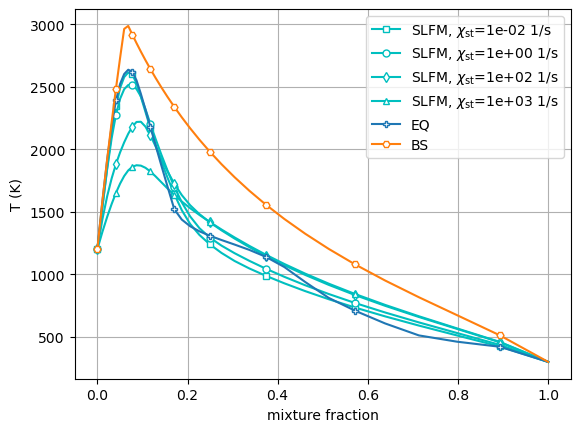

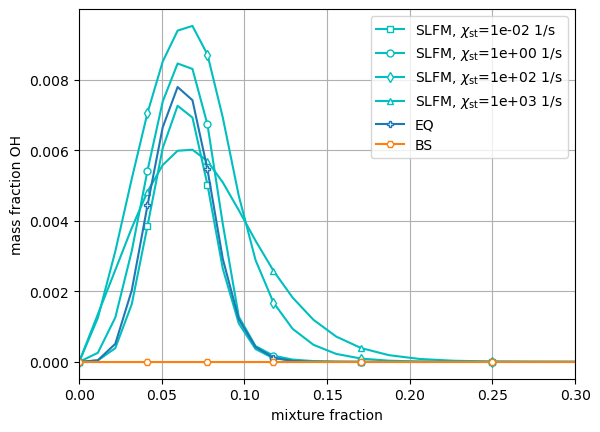

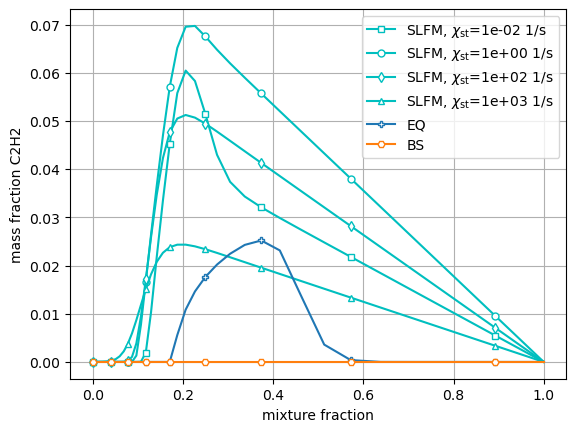

In [4]:
chi_indices_plot = [0, 2, 4, 5]
chi_values = l_sl.dim('dissipation_rate_stoich').values
z = l_sl.dim('mixture_fraction').values

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['temperature'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['temperature'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['temperature'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['mass fraction OH'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['mass fraction OH'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['mass fraction OH'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('mass fraction OH')
plt.xlim([0, 0.3])
plt.grid(True)
plt.legend(loc='best')
plt.show()

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['mass fraction C2H2'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['mass fraction C2H2'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['mass fraction C2H2'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('mass fraction C2H2')
plt.grid(True)
plt.legend(loc='best')
plt.show()